# 增强学习：多臂赌博机模型

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## 环境建模，给定摇臂行为，返回回报
预置设为臂4值最小，根据getRward()函数会有最大回报

In [2]:
bandits = [5, 1.2, -0.3, -5.0]
num_bandits = len(bandits)

def getReward(bandit):
    r = np.random.randn(1)
    if r>bandit:
        return 1
    else:
        return -1

## Agent建模1
平均累积回报函数

In [3]:
class QAvg:
    def __init__(self, num_bandits):
        self.k = np.zeros(num_bandits)
        
    def getOptAction(self):
        return self.k.argmax()
    
    def update(self, count, action, reward):
        self.k[action] += (self.getOptAction()*count + reward)/(count+1)
        
    def printRewards(self):
        print self.k

贪心策略训练

In [4]:
def greed_train_qavg(total_episode, e, Q):
    for count in range(total_episode):
        # 均匀分布
        r = np.random.rand(1)
        if  r < e:
            action = np.random.randint(num_bandits)
        else:
            action = Q.getOptAction()

        reward = getReward(bandits[action])
        Q.update(action=action, count=count+1, reward=reward)
    return Q.getOptAction()+1

## Agent建模2
神经网络回报函数，对Q价值函数的近似

In [5]:
lr = 0.001
tf.reset_default_graph()
            
reward_holder = tf.placeholder(tf.float32, shape=[1])
action_holder = tf.placeholder(tf.int32, shape=[1])

weight = tf.Variable(tf.ones(num_bandits))
chosen_action = tf.argmax(weight, axis=0)

response_weight = tf.slice(weight, action_holder, size=[1])
loss = -(tf.log(response_weight)*reward_holder)
update = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

贪心策略训练

In [6]:
def greed_train_qnetwork(total_episode, e):
    total_reward = np.zeros(num_bandits)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for count in range(total_episode):
            r = np.random.randn(1)
            if r<e:
                action = np.random.randint(num_bandits)
            else:
                action = sess.run(chosen_action)

            reward = getReward(bandits[action])
            sess.run(update, feed_dict={action_holder: [action], reward_holder: [reward]})
            total_reward[action] += reward
    return total_reward.argmax()+1

## 效果对比验证

In [7]:
x,y = [],[]
for i in range(50):
    x.append( greed_train_qavg(10000, 0.5, QAvg(num_bandits)) )
    y.append( greed_train_qnetwork(500, 0.5) )

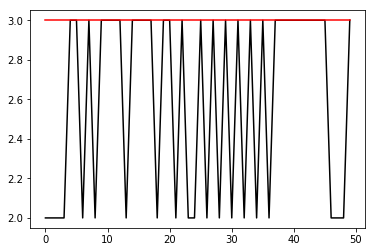

In [8]:
plt.plot(x, color="k")
plt.plot(y, color="r")